# IBM DATA SCIENCE CAPSTONE PROJECT 

## Analysis of Bangalore City, India on neighborhood(venues,location...) Data to find the best locations to open a fitness centre using Foursquare APIs and K-Means Clustering method.

#### Importing all required libraries!

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis


import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't installed 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Loading Bangalore Neighborhood Dataset from Kaggle

In [2]:
dfs = pd.read_html('https://github.com/inboxpraveen/Coursera_capstone/blob/master/data/complete_dataset.csv')
df = dfs[0]
df.head()

,Unnamed: 0,Unnamed: 1,Borough,Neighborhoods,Latitude,Longitude,Population,City,AverageIncome
0,NaN,0,Central,Cantonment area,12.972442,77.580643,866377,Bangalore,18944.099792
1,NaN,1,Central,Domlur,12.960992,77.638726,743186,Bangalore,56837.022198
2,NaN,2,Central,Indiranagar,12.971891,77.641151,474289,Bangalore,41991.817435
3,NaN,3,Central,Jeevanbheemanagar,12.962900,77.659500,527874,Bangalore,6667.447632
4,NaN,4,Central,Malleswaram,13.003100,77.564300,893629,Bangalore,53270.063892


In [3]:
df.drop(columns = ['Unnamed: 0','Unnamed: 1','City'], inplace = True)
df.head()

,Borough,Neighborhoods,Latitude,Longitude,Population,AverageIncome
0,Central,Cantonment area,12.972442,77.580643,866377,18944.099792
1,Central,Domlur,12.960992,77.638726,743186,56837.022198
2,Central,Indiranagar,12.971891,77.641151,474289,41991.817435
3,Central,Jeevanbheemanagar,12.962900,77.659500,527874,6667.447632
4,Central,Malleswaram,13.003100,77.564300,893629,53270.063892


In [4]:
df['Borough'].nunique() #total no of boroughs

8

In [5]:
df['Borough'].unique() #list of boroughs

array(['Central', 'Eastern', 'NorthEastern', 'Northern', 'SouthEastern',
       'Southern', 'SouthernSuburbs', 'Western'], dtype=object)

#### Boroughs vs Number of Neighborhoods

In [6]:
df_1 = df[['Borough','Neighborhoods']]
df_grp1 = df_1.groupby(['Borough'], as_index = False).count() #arranging no of neighborhoods and boroughs
df_grp1

,Borough,Neighborhoods
0,Central,12
1,Eastern,8
2,NorthEastern,6
3,Northern,8
4,SouthEastern,7
5,Southern,8
6,SouthernSuburbs,6
7,Western,9


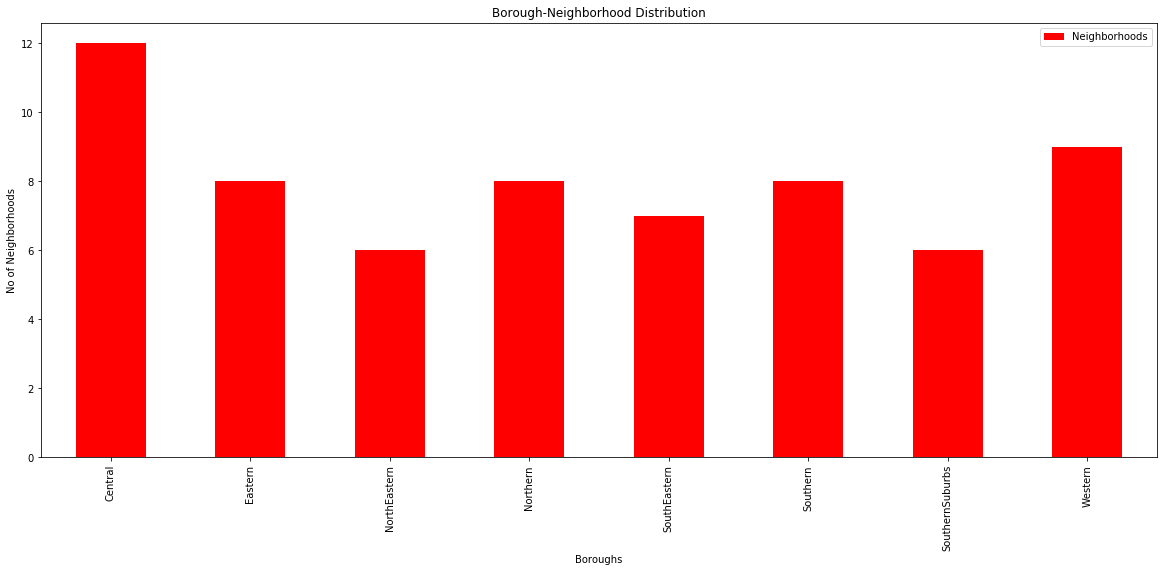

In [7]:
#plotting a graph
df_grp1.plot(kind = 'bar',figsize=(20, 8),color = 'red')
plt.ylabel('No of Neighborhoods')
plt.xlabel('Boroughs')
labels = df['Borough'].unique()
ticks = np.arange(0,8,1)
plt.xticks(ticks,labels)
plt.title('Borough-Neighborhood Distribution')
plt.show()


#### Neighbohoods vs Population

In [8]:
df_2 = df[['Neighborhoods','Population']]
df_grp2 = df_2.groupby(['Neighborhoods'], as_index = False).max()
df_grp2.head()

,Neighborhoods,Population
0,Anjanapura,940039
1,Arekere,138760
2,BTM Layout,835743
3,Banashankari,810407
4,Banaswadi,632031


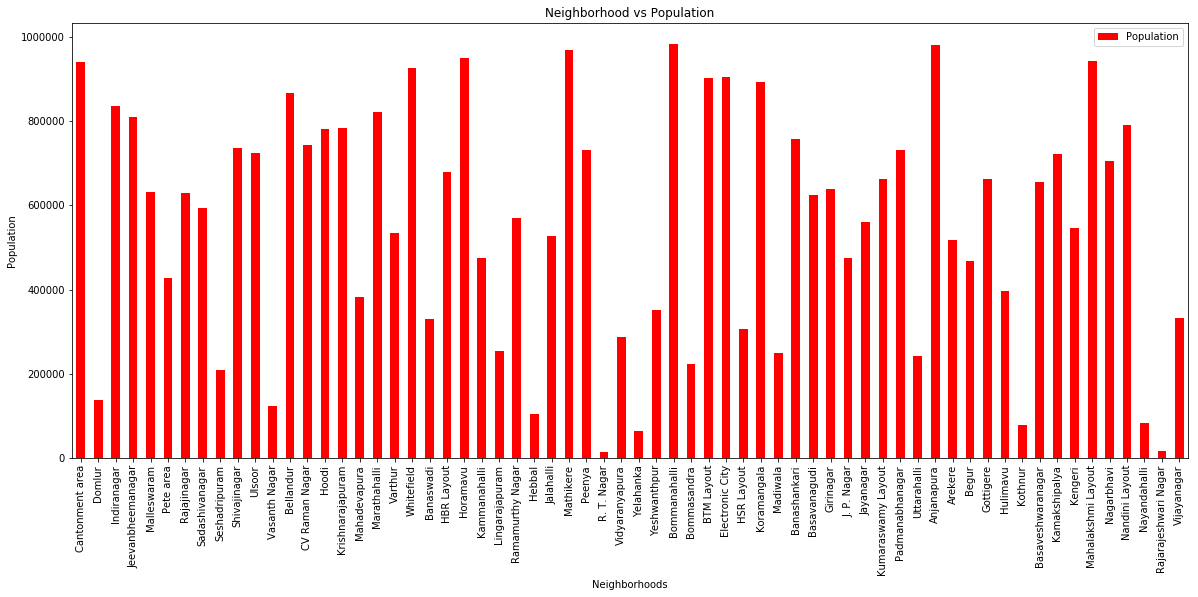

In [9]:
df_grp2.plot(kind = 'bar',stacked = False,color = 'red',figsize=(20, 8))
plt.ylabel('Population')
plt.xlabel('Neighborhoods')
labels = df['Neighborhoods'].unique()
ticks = np.arange(0,64,1)
plt.xticks(ticks,labels)
plt.title('Neighborhood vs Population')
plt.show()

#### Neighborhood vs Average Income 

In [10]:
df_3 = df[['Neighborhoods','AverageIncome']]
df_grp3 = df_3.groupby(['Neighborhoods'], as_index = False).max()
df_grp3.head()

,Neighborhoods,AverageIncome
0,Anjanapura,44218.922553
1,Arekere,29378.716626
2,BTM Layout,49310.618884
3,Banashankari,57524.209528
4,Banaswadi,53349.701184


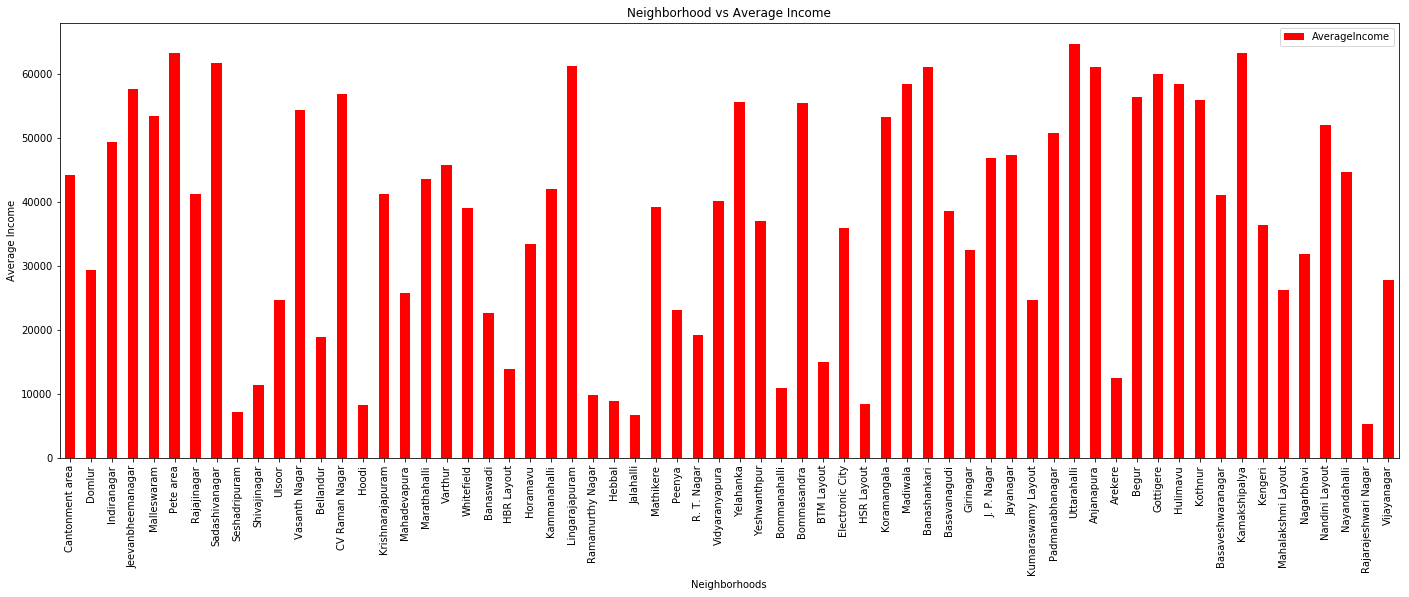

In [11]:
#color = ['red','orange','yellow','green','purple','blue','voilet','black','grey','brown']
df_grp3.plot(kind = 'bar',stacked = False,color = 'red' ,figsize=(24, 8))
plt.ylabel('Average Income')
plt.xlabel('Neighborhoods')
labels = df['Neighborhoods'].unique()
ticks = np.arange(0,64,1)
plt.xticks(ticks,labels)
plt.title('Neighborhood vs Average Income')
plt.show()

### We see how different regions have different population,average income and their distribution different areas of Bangalore. This gives us the holistic idea of the dataset. 

### Creating a Map of Bangalore 

In [12]:
#getting the co-ordinates of Bangalore
geolocator = Nominatim(user_agent = "bangalore_explorer") 
location = geolocator.geocode("Bangalore")
print(location.address) 
print("The Geographical Coordinates of Bangalore are {}, {}".format(location.latitude, location.longitude))

Bengaluru, Doctor B R Ambedkar Veedhi, Sampangirama Nagar, Sampangiram Nagar Ward, East Zone, Bengaluru, Bangalore North, Bangalore Urban, Karnataka, 560001, India
The Geographical Coordinates of Bangalore are 12.9791198, 77.5912997


In [13]:
# create map of Bangalore using latitude and longitude values
latitude = location.latitude
longitude = location.longitude
map_bangalore = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhoods']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat, lng]).add_to(map_bangalore)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0,
        parse_html=False).add_to(map_bangalore)  
    
map_bangalore

#### We can see the different Neighborhoods(Areas) marked covering the entire Bangalore.

### Lets now explore each Neighborhood in detail using foursquare API 

In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:
df.head()

,Borough,Neighborhoods,Latitude,Longitude,Population,AverageIncome
0,Central,Cantonment area,12.972442,77.580643,866377,18944.099792
1,Central,Domlur,12.960992,77.638726,743186,56837.022198
2,Central,Indiranagar,12.971891,77.641151,474289,41991.817435
3,Central,Jeevanbheemanagar,12.962900,77.659500,527874,6667.447632
4,Central,Malleswaram,13.003100,77.564300,893629,53270.063892


In [16]:
df.iloc[0,1]

'Cantonment area'

##### So for start we will Cantonment area in Central Bangalore and see what we get.

In [17]:
neighborhood_latitude = df.iloc[0, 2] # neighborhood latitude value
neighborhood_longitude = df.iloc[0, 3] # neighborhood longitude value

neighborhood_name = df.iloc[0, 1] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))
print('Population - {} , Average Income - {} Rupees'.format(df.iloc[0,4],df.iloc[0,5]))

Latitude and longitude values of Cantonment area are 12.972442, 77.58064300000001.
Population - 866377 , Average Income - 18944.09979245654 Rupees


#### Using Foursquare API, exploring area under 1000m radius of Cantonment area

In [18]:
LIMIT = 1000
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)


url

'https://api.foursquare.com/v2/venues/explore?&client_id=KM4N2DKSD15QQQ0QQ3ST5EEPPD2IVHNIVSQEPSLVZBPI25GA&client_secret=0CHY21SAUUDNMSANXACNVRL12OT3B0XYYKVLMSFXYQT3RM1B&v=20180605&ll=12.972442,77.58064300000001&radius=1000&limit=1000'

In [19]:
results = requests.get(url).json() #getting json file from the foursquare

#### Creating a function which extracts the category of the venue

In [20]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Loading JSON data into Pandas Dataframe

In [21]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Hotel Fishland,Seafood Restaurant,12.975569,77.578592
1,Lakshmi Nataraj Refreshments,South Indian Restaurant,12.967476,77.579468
2,Chikkana Tiffin Room,Indian Restaurant,12.968557,77.584282
3,Udupi Sri Krishna Bhavan,Indian Restaurant,12.971563,77.574158
4,Freedom Park,Park,12.978008,77.582373


In [22]:
#No of venues were returned by Foursquare
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

29 venues were returned by Foursquare.


### Let's create a function to repeat the same process to all the neighborhoods in Bangalore

In [23]:
def getNearbyVenues(names, boro, latitudes, longitudes, radius=1250):   #increasing radius to cover more areas
    
    venues_list=[]
    for name, boro, lat, lng in zip(names, boro, latitudes, longitudes):
        #print("Fetching venues for : ",name)            
        # create the API request URL
        LIMIT = 1000
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            boro,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Borough',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [24]:
bangalore_venues = getNearbyVenues(names=df['Neighborhoods'],latitudes=df['Latitude'],longitudes=df['Longitude'],boro=df['Borough'])

In [25]:
print(bangalore_venues.shape)
bangalore_venues.head()

(2379, 8)


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cantonment area,Central,12.972442,77.580643,Hotel Fishland,12.975569,77.578592,Seafood Restaurant
1,Cantonment area,Central,12.972442,77.580643,Lakshmi Nataraj Refreshments,12.967476,77.579468,South Indian Restaurant
2,Cantonment area,Central,12.972442,77.580643,Chikkana Tiffin Room,12.968557,77.584282,Indian Restaurant
3,Cantonment area,Central,12.972442,77.580643,Udupi Sri Krishna Bhavan,12.971563,77.574158,Indian Restaurant
4,Cantonment area,Central,12.972442,77.580643,SGS Donne Biriyani,12.970325,77.572648,Indian Restaurant


#### This Data may contain duplicate venues as the radius of two or more neighborhoods may overlap. 

In [26]:
bangalore_venues.drop_duplicates(subset = ['Venue Latitude', 'Venue Longitude'], inplace = True) #remove duplicacy
bangalore_venues.shape

(2030, 8)

In [27]:
duplicate_rows = bangalore_venues[bangalore_venues.duplicated(['Venue', 'Venue Latitude', 'Venue Longitude'])] #checking
duplicate_rows.shape

(0, 8)

In [28]:
bangalore_venues.groupby('Venue Category').count()['Neighborhood'].sort_values(ascending=False).head(25)

Venue Category
Indian Restaurant                347
Café                             141
Fast Food Restaurant              93
Coffee Shop                       72
Ice Cream Shop                    67
Pizza Place                       65
Chinese Restaurant                62
Hotel                             50
Bakery                            50
Department Store                  48
Vegetarian / Vegan Restaurant     34
Italian Restaurant                29
Lounge                            28
Asian Restaurant                  27
Sandwich Place                    27
Restaurant                        27
Clothing Store                    26
Bus Station                       25
Pub                               25
Gym                               24
Bar                               23
Breakfast Spot                    22
Snack Place                       22
South Indian Restaurant           21
Dessert Shop                      17
Name: Neighborhood, dtype: int64

In [29]:
print('There are {} uniques categories.'.format(bangalore_venues['Venue Category'].nunique()))

There are 204 uniques categories.


### Neighborhood vs Number of Venues

In [30]:
individual_bangalore_venue_count = bangalore_venues.groupby(['Borough','Neighborhood'])['Venue'].count().to_frame()
individual_bangalore_venue_count.head(15)

Venue
Borough Neighborhood            
Central Cantonment area       39
        Domlur               100
        Indiranagar           56
        Jeevanbheemanagar     41
        Malleswaram           46
        Pete area             11
        Rajajinagar           36
        Sadashivanagar        37
        Seshadripuram         81
        Shivajinagar         100
        Ulsoor                37
        Vasanth Nagar         45
Eastern Bellandur             61
        CV Raman Nagar        43
        Hoodi                 13

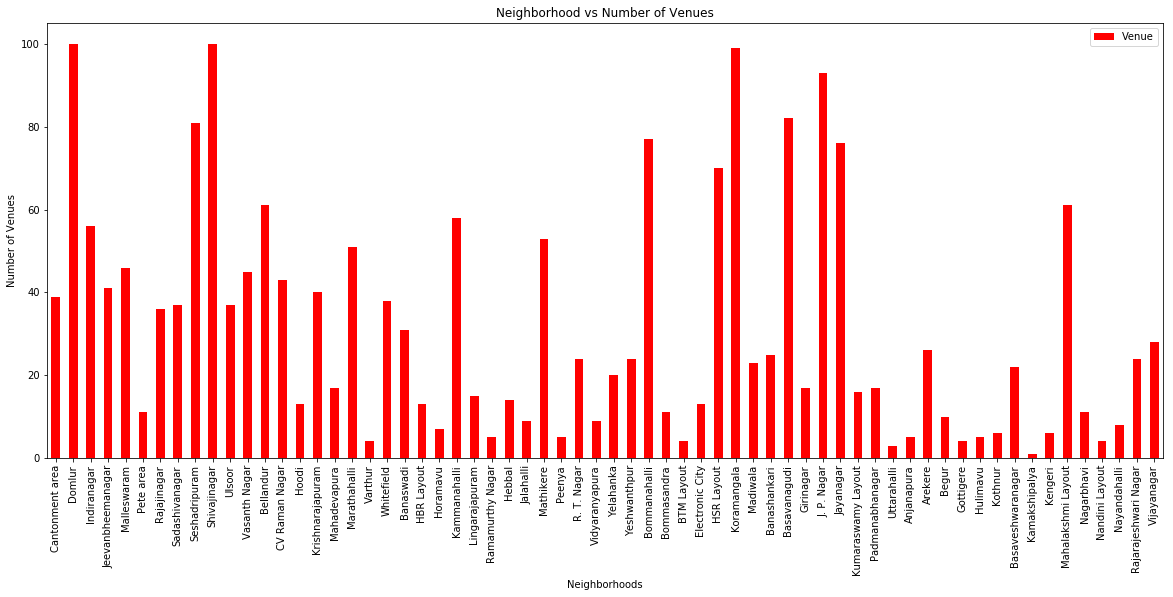

In [31]:
individual_bangalore_venue_count.rename(columns={'Borough':'NumberOfVenues'},inplace=True)
individual_bangalore_venue_count.reset_index(inplace=True)

individual_bangalore_venue_count.plot(kind = 'bar',stacked = False,color = 'red',figsize=(20, 8))
plt.ylabel('Number of Venues')
plt.xlabel('Neighborhoods')
labels = df['Neighborhoods'].unique()
ticks = np.arange(0,64,1)
plt.xticks(ticks,labels)
plt.title('Neighborhood vs Number of Venues')
plt.show()




#import seaborn as sns
#sns.set(rc={'figure.figsize':(20,10)})
#plot = sns.barplot(x='Neighborhood',y='NumberOfVenues',data=individual_bangalore_venue_count)
#plot.set_xticklabels(individual_bangalore_venue_count['Neighborhood'],rotation=90)

#### We can see different number of venues in different neighborhoods in Bangalore. Few areas like. have relatively higher number than areas like ..

### Gyms in Bangalore

In [32]:
bangalore_gyms = bangalore_venues[bangalore_venues['Venue Category'].str.contains('Gym')]
bangalore_gyms.head(10)

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
196,Indiranagar,Central,12.971891,77.641151,The Tribe Cult Fitness,12.980738,77.640515,Gym / Fitness Center
272,Jeevanbheemanagar,Central,12.962900,77.659500,Fitness Square,12.958954,77.660055,Gym
382,Rajajinagar,Central,12.990100,77.552500,Snap Fitness,12.999476,77.549761,Gym
400,Sadashivanagar,Central,13.006800,77.581300,Affinity Gym,13.009358,77.579678,Gym
414,Sadashivanagar,Central,13.006800,77.581300,Fitness One,13.001221,77.577104,Gym
544,Seshadripuram,Central,12.993500,77.578700,ITC Windsor gym,12.994101,77.585552,Gym / Fitness Center
772,Vasanth Nagar,Central,12.991100,77.592000,Energy Fitness Centre,12.989589,77.597131,Gym / Fitness Center
810,Bellandur,Eastern,12.926000,77.676200,Sobha Lakeview Clubhouse,12.929097,77.672374,Gym
835,Bellandur,Eastern,12.926000,77.676200,Snap Fitness,12.923152,77.669660,Gym
850,CV Raman Nagar,Eastern,12.985500,77.663900,Gold's Gym,12.994386,77.660744,Gym


#### Gyms in Neighborhoods

In [33]:
df_gyms = bangalore_gyms[['Neighborhood','Venue']]
df_grp_gym = df_gyms.groupby(['Neighborhood'], as_index = False).count() #arranging no of neighborhoods and boroughs
df_grp_gym.rename(columns={"Venue": "Number of Gyms"},inplace = True)
df_grp_gym.head(10)

,Neighborhood,Number of Gyms
0,BTM Layout,1
1,Basaveshwaranagar,2
2,Bellandur,2
3,CV Raman Nagar,1
4,HSR Layout,2
5,Horamavu,1
6,Indiranagar,1
7,J. P. Nagar,2
8,Jayanagar,1
9,Jeevanbheemanagar,1


#### Lets plot the gyms on a map

In [34]:
map_bangalore = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, venue, neighborhood in zip(bangalore_gyms['Venue Latitude'], bangalore_gyms['Venue Longitude'], bangalore_gyms['Venue'], bangalore_gyms['Neighborhood']):
    label = '{}, {}'.format(venue,neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat, lng]).add_to(map_bangalore)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0,
        parse_html=False).add_to(map_bangalore)  
    
map_bangalore

### Clustering

#### Creating a dataframe which will be used for clustering.

In [35]:
df_grp_gym.head()

,Neighborhood,Number of Gyms
0,BTM Layout,1
1,Basaveshwaranagar,2
2,Bellandur,2
3,CV Raman Nagar,1
4,HSR Layout,2


In [36]:
df.head()

,Borough,Neighborhoods,Latitude,Longitude,Population,AverageIncome
0,Central,Cantonment area,12.972442,77.580643,866377,18944.099792
1,Central,Domlur,12.960992,77.638726,743186,56837.022198
2,Central,Indiranagar,12.971891,77.641151,474289,41991.817435
3,Central,Jeevanbheemanagar,12.962900,77.659500,527874,6667.447632
4,Central,Malleswaram,13.003100,77.564300,893629,53270.063892


#### Putting Neighborhood, Number of Gyms, Population and Average Income together in one Dataframe.

In [37]:
column = ['Neighborhoods','Number of Gyms','Population','AverageIncome']
cluster_df = pd.DataFrame(columns=column)
cluster_df['Neighborhoods'] = df['Neighborhoods']
cluster_df['Population'] = df['Population']
cluster_df['AverageIncome'] = df['AverageIncome']
cluster_df.head()

,Neighborhoods,Number of Gyms,Population,AverageIncome
0,Cantonment area,NaN,866377,18944.099792
1,Domlur,NaN,743186,56837.022198
2,Indiranagar,NaN,474289,41991.817435
3,Jeevanbheemanagar,NaN,527874,6667.447632
4,Malleswaram,NaN,893629,53270.063892


In [38]:
for i,row in cluster_df.iterrows() :
    cluster_df.loc[i,'Number of Gyms'] = 0
            
for idx, row in cluster_df.iterrows() :
    for idx1,row1 in df_grp_gym.iterrows() :
        if cluster_df.loc[idx,'Neighborhoods'] == df_grp_gym.loc[idx1,'Neighborhood'] :
            cluster_df.loc[idx,'Number of Gyms'] = df_grp_gym.loc[idx1,'Number of Gyms']

cluster_df.head()

,Neighborhoods,Number of Gyms,Population,AverageIncome
0,Cantonment area,0,866377,18944.099792
1,Domlur,0,743186,56837.022198
2,Indiranagar,1,474289,41991.817435
3,Jeevanbheemanagar,1,527874,6667.447632
4,Malleswaram,0,893629,53270.063892


#### Lets now find the number of clusters required using elbow method.

In [39]:
sse = {}
for k in range(1,15):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(cluster_df.drop(columns = ['Neighborhoods','Population','AverageIncome'],axis=1))
    cluster_df['Cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/clu

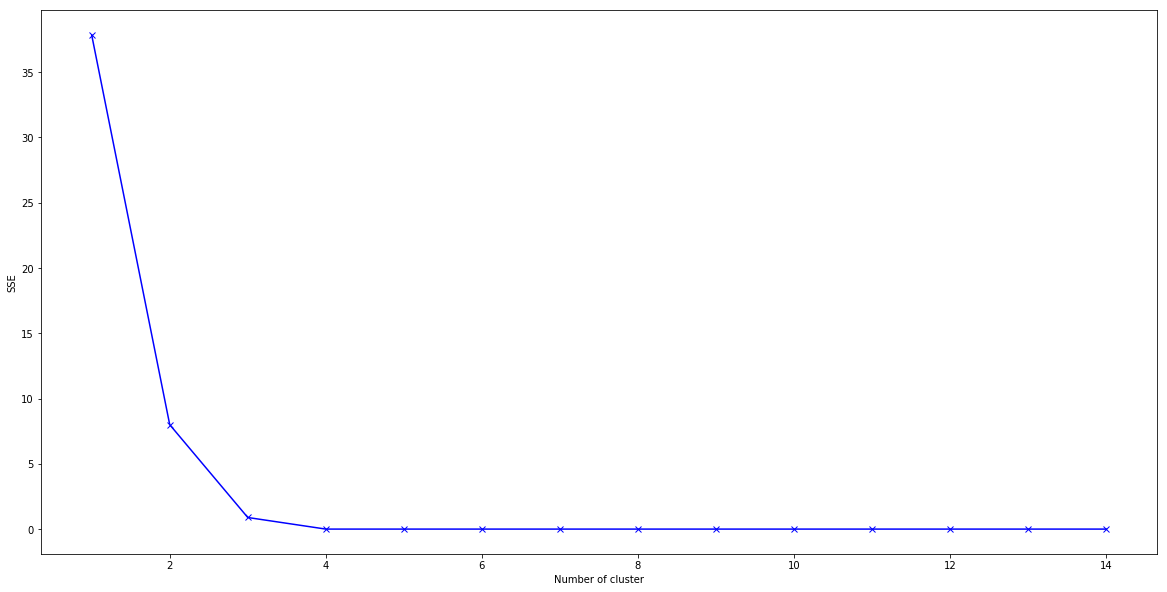

In [40]:
plt.figure(figsize=(20,10))
plt.plot(list(sse.keys()), list(sse.values()),'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### From the above graph, we can see the optimal value for k is 3

In [51]:
kmeans = KMeans(n_clusters=3,random_state=0)
kmeans.fit(cluster_df.drop(['Neighborhoods','Population','AverageIncome'],axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [52]:
cluster_df['Cluster'] = kmeans.labels_
cluster_df.groupby('Cluster')['Neighborhoods'].count()

Cluster
0     9
1    39
2    16
Name: Neighborhoods, dtype: int64

In [53]:
cluster_df_sorted = df[['Neighborhoods','Latitude','Longitude']]
cluster_df_sorted = cluster_df_sorted.merge(cluster_df,on = 'Neighborhoods')
cluster_df_sorted.head()

,Neighborhoods,Latitude,Longitude,Number of Gyms,Population,AverageIncome,Cluster
0,Cantonment area,12.972442,77.580643,0,866377,18944.099792,1
1,Domlur,12.960992,77.638726,0,743186,56837.022198,1
2,Indiranagar,12.971891,77.641151,1,474289,41991.817435,2
3,Jeevanbheemanagar,12.962900,77.659500,1,527874,6667.447632,2
4,Malleswaram,13.003100,77.564300,0,893629,53270.063892,1


#### Creating Folium map to show different clusters

In [54]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

#color scheme
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_df_sorted['Latitude'], cluster_df_sorted['Longitude'], cluster_df_sorted['Neighborhoods'], cluster_df_sorted['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters    

### Now We will examine each cluster!

In [55]:
cluster_df.loc[cluster_df['Cluster'] == 0].head()

,Neighborhoods,Number of Gyms,Population,AverageIncome,Cluster
7,Sadashivanagar,2,662625,59943.541564,0
12,Bellandur,2,208094,7227.731930,0
19,Whitefield,2,83029,44637.984599,0
28,Mathikere,2,757626,61046.854723,0
38,HSR Layout,2,534598,45739.216291,0


In [63]:
cluster1 = cluster_df.loc[cluster_df['Cluster'] == 1]
cluster1.head()

,Neighborhoods,Number of Gyms,Population,AverageIncome,Cluster
0,Cantonment area,0,866377,18944.099792,1
1,Domlur,0,743186,56837.022198,1
4,Malleswaram,0,893629,53270.063892,1
5,Pete area,0,730999,50712.430215,1
9,Shivajinagar,0,77836,55850.962099,1


In [61]:
cluster2 = cluster_df.loc[cluster_df['Cluster'] == 2]
cluster2.head()

,Neighborhoods,Number of Gyms,Population,AverageIncome,Cluster
2,Indiranagar,1,474289,41991.817435,2
3,Jeevanbheemanagar,1,527874,6667.447632,2
6,Rajajinagar,1,981362,60967.535874,2
8,Seshadripuram,1,396862,58407.090338,2
11,Vasanth Nagar,1,942711,26168.448092,2


### We see that in Cluster 0 & 2 : There are gyms available and in Cluster 1 : There are no gyms at all.

### So we will look into Cluster 1 for the ideal location.

##### Neighborhood vs Population vs Average Income 

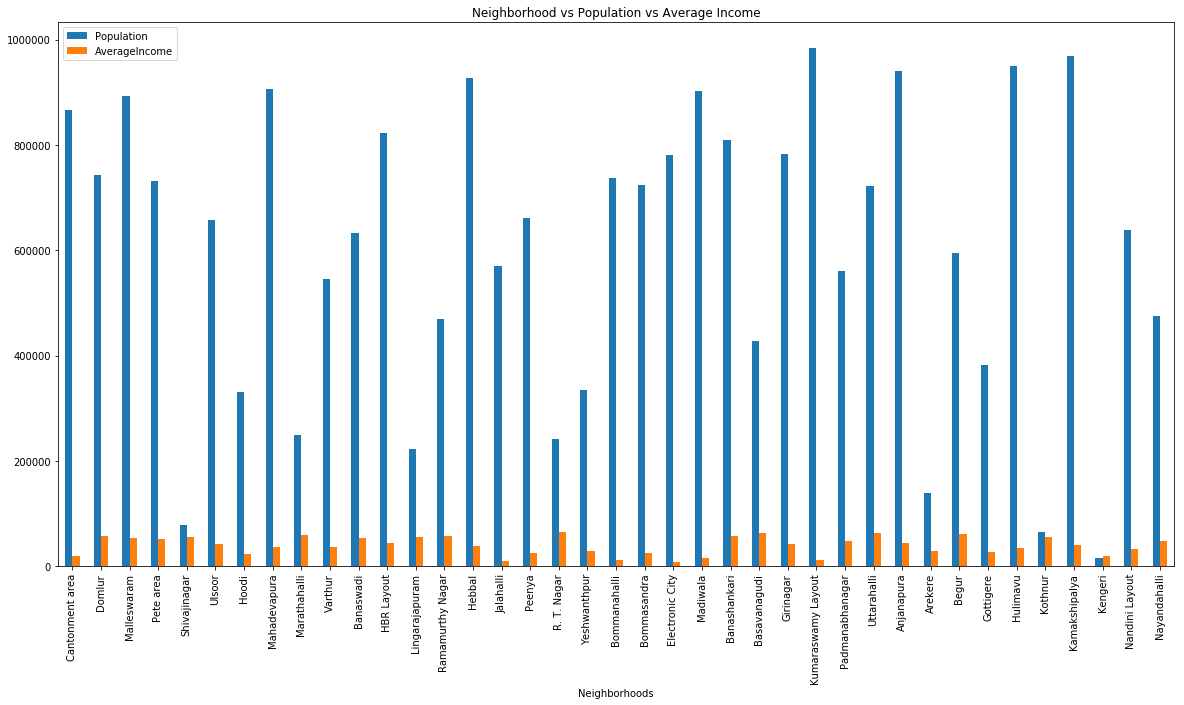

In [64]:
cluster1.drop(['Number of Gyms','Cluster'],axis = 1).plot(kind = 'bar',figsize=(20,10))
labels = cluster1['Neighborhoods'].unique()
ticks = np.arange(0,39,1)
plt.xticks(ticks,labels)
plt.xlabel("Neighborhoods")
plt.title("Neighborhood vs Population vs Average Income")
plt.show()

#### The ideal location for the premium fitness centre would be a place where people's Avg Income would be High.

##### Displaying top 10 areas with relatively high average income.

In [65]:
final = cluster1.sort_values('AverageIncome', ascending=False)
final.head(10)

,Neighborhoods,Number of Gyms,Population,AverageIncome,Cluster
30,R. T. Nagar,0,241187,64644.480986,1
48,Uttarahalli,0,722264,63166.190375,1
42,Basavanagudi,0,426903,63161.962218,1
51,Begur,0,594887,61640.098297,1
17,Marathahalli,0,249182,58448.658524,1
41,Banashankari,0,810407,57524.209528,1
1,Domlur,0,743186,56837.022198,1
25,Ramamurthy Nagar,0,468662,56428.329775,1
9,Shivajinagar,0,77836,55850.962099,1
54,Kothnur,0,65249,55508.825047,1


#### Now We should foucs on areas with high population among these Neigborhoods with High Avg Income

In [66]:
final = final.head(10)
final = final.sort_values('Population', ascending = False)
final.head()

,Neighborhoods,Number of Gyms,Population,AverageIncome,Cluster
41,Banashankari,0,810407,57524.209528,1
1,Domlur,0,743186,56837.022198,1
48,Uttarahalli,0,722264,63166.190375,1
51,Begur,0,594887,61640.098297,1
25,Ramamurthy Nagar,0,468662,56428.329775,1


### So These are the top 5 Neighborhoods which is ideal location for the Premium Fitness Centre

In [67]:
final_loc = final.merge(df, on = 'Neighborhoods')
final_loc[['Borough','Neighborhoods','Population_x','AverageIncome_x']].head()

,Borough,Neighborhoods,Population_x,AverageIncome_x
0,Southern,Banashankari,810407,57524.209528
1,Central,Domlur,743186,56837.022198
2,Southern,Uttarahalli,722264,63166.190375
3,SouthernSuburbs,Begur,594887,61640.098297
4,NorthEastern,Ramamurthy Nagar,468662,56428.329775


### Banashankari in Southern Bengaluru is The Best Choice as its Population is 810407 and also AverageIncome of the people is 57524.2 Rs

### Thank You!